In [42]:
import pandas as pd
import json
import requests
from collections import Counter
from pprint import pprint

In [23]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
# set the default plot size
pylab.rcParams['figure.figsize'] = (12, 6)

In [27]:
# load player prospect data
players = pd.read_csv('2018_prospect_players.csv')

In [28]:
# inspect the DataFrame
players.head()

,player_first_name,player_id,player_last_name,position,preseason100,preseason20,prospect_year,rank,team_file_code
0,Nick,669222,Senzel,3B,7,1.0,2018,1,CIN
1,Hunter,668881,Greene,RHP,21,2.0,2018,2,CIN
2,Taylor,666211,Trammell,OF,43,3.0,2018,3,CIN
3,Jesse,608385,Winker,OF,82,4.0,2018,4,CIN
4,Tyler,641816,Mahle,RHP,84,5.0,2018,5,CIN


In [29]:
# are some players listed multiple times?
players['player_id'].value_counts()[:5]

656713    4
660271    4
663656    3
660670    3
669222    3
Name: player_id, dtype: int64

In [30]:
# lets look at these players that are listed multiple times
players[players['player_id'] == '656713']

,player_first_name,player_id,player_last_name,position,preseason100,preseason20,prospect_year,rank,team_file_code
30,Brendan,656713,McKay,1B/LHP,NaN,NaN,2018,1,TB
44,Brendan,656713,McKay,1B/LHP,25,NaN,2018,5,TB
424,Brendan,656713,McKay,1B/LHP,25,3.0,2018,25,TB
622,Brendan,656713,McKay,1B/LHP,25,3.0,2018,3,TB


In [31]:
# grab the unique player_id from the DataFrame
player_ids = players['player_id'].unique().tolist()

In [32]:
# how many unique players are there?
len(player_ids)

950

In [37]:
# get data for each player
responses = []
for i in player_ids:
    r = requests.get("http://m.mlb.com/gen/players/prospects/2018/{}.json".format(i))
    responses.append(r)

In [45]:
# what is the status of the responses received
Counter([i.status_code for i in responses])

Counter({200: 950})

In [226]:
# extract the content from each response
data = []
for line in responses:
    line = json.loads(line.text)
    data.append(line['prospect_player'])

In [227]:
# look at the dictionary keys in the first record
data[0].keys()

dict_keys(['player_last_name', 'drafted', 'thrw', 'player_first_name', 'content', 'preseason20', 'year', 'birthdate', 'team_file_code', 'positions', 'player_id', 'bats', 'height', 'weight', 'eta', 'signed', 'twitter', 'school', 'preseason100'])

In [228]:
# inspect the first record
pprint(data[0])

{'bats': '',
 'birthdate': '',
 'content': {'default': '<b>Scouting grades:</b> Hit: 70 | Power: 55 | Run: 55 '
                        '| Arm: 60 | Field: 60 | Overall: 65\n'
                        '<p>Billed as the top pure hitter in the 2016 Draft '
                        'class, especially from the college ranks, the hope '
                        'was Senzel would be the type who could move quickly '
                        'through a farm system. After the Tennessee product '
                        "went No. 2 overall to the Reds, he's lived up to that "
                        'billing, hitting his way to Double-A in his first '
                        'full season and actually hitting better once he got '
                        'to that advanced level.\n'
                        '<p>Senzel uses a combination of strength, bat speed '
                        'and an advanced approach at the plate to be an '
                        'extremely dangerous hitter from the right si

In [229]:
# iterate over data and clean up the content
for line in data:
    
    # remove newline delimiter
    bio = line['content']['default'].replace('\n', '').strip()
    
    # conform scouting grades
    variations = ['<b>Scouting grades:</b>', 
                  '<b>Scouting grades</b>:', 
                  '<b>Scouting grades</b>:', 
                  '<b>Scouting Grades:</b>',
                  '<p>Scouting Grades:</b>',
                  '<p><b>Scouting Grades:</b> Scouting Grades:']
    
    for i in variations:
        if bio.startswith(i):
            bio = bio.replace(i, 'Scouting Grades')
    
    # split the bio on paragraph tag
    bio = bio.split('<p>')
    
    # create a new key to hold bio
    line['bio'] = bio

In [230]:
# inspect the new bio 
pprint(data[0]['bio'])

['Scouting Grades Hit: 70 | Power: 55 | Run: 55 | Arm: 60 | Field: 60 | '
 'Overall: 65',
 'Billed as the top pure hitter in the 2016 Draft class, especially from the '
 'college ranks, the hope was Senzel would be the type who could move quickly '
 'through a farm system. After the Tennessee product went No. 2 overall to the '
 "Reds, he's lived up to that billing, hitting his way to Double-A in his "
 'first full season and actually hitting better once he got to that advanced '
 'level.',
 'Senzel uses a combination of strength, bat speed and an advanced approach at '
 'the plate to be an extremely dangerous hitter from the right side of the '
 "plate. He makes consistent hard contact, doesn't strike out a lot and draws "
 'walks, which points to a future of hitting over .300 and perhaps competing '
 "for batting titles. While he's not a pure power type, he did have 57 "
 'extra-base hits in 2017 and homered 10 times in 209 at-bats in Double-A. '
 "He's not a burner on the basepaths,

In [231]:
# iterate over data and extract scouting grades into new keys
for line in data:
    
    # create an empty container to hold non-scouting grades
    bio = []
    
    # iterate over the bio key specifically
    for item in line['bio']:
    
        # get the line that starts with scouting grades
        if item.startswith('Scouting Grades'):

            # remove the beginning of the sententce
            grades = item.replace('Scouting Grades', '')
            
            # address edge case with missing colon
            grades = grades.replace('Arm ', 'Arm:')
            grades = grades.replace('Control ', 'Control:')

            # split in seperate metrics
            metrics = grades.split('|')

            # iterate over the metrics
            for i in metrics:

                # seperate the metric from the value
                value = i.split(':')

                # add metrics and values as new keys/values
                line[value[0].strip()] = value[1].strip()
                
        # if it's not a scouting grade...
        else:
            
            # add to bio
            bio.append(item)
            
    # join the bio text into one string
    line['bio'] = ''.join(bio)

In [232]:
# inspect one record
pprint(data[0])

{'Arm': '60',
 'Field': '60',
 'Hit': '70',
 'Overall': '65',
 'Power': '55',
 'Run': '55',
 'bats': '',
 'bio': 'Billed as the top pure hitter in the 2016 Draft class, especially '
        'from the college ranks, the hope was Senzel would be the type who '
        'could move quickly through a farm system. After the Tennessee product '
        "went No. 2 overall to the Reds, he's lived up to that billing, "
        'hitting his way to Double-A in his first full season and actually '
        'hitting better once he got to that advanced level.Senzel uses a '
        'combination of strength, bat speed and an advanced approach at the '
        'plate to be an extremely dangerous hitter from the right side of the '
        "plate. He makes consistent hard contact, doesn't strike out a lot and "
        'draws walks, which points to a future of hitting over .300 and '
        "perhaps competing for batting titles. While he's not a pure power "
        'type, he did have 57 extra-base hit

In [233]:
# iterate over data convert values to integers where possible
for line in data:
    for key in line:
        try:
            line[key] = int(line[key])
        except:
            pass

In [234]:
# load data into a DataFrame
df = pd.DataFrame(data)

In [235]:
# convert column names to lowercase
df.columns = df.columns.str.lower()

In [236]:
# inspect the DataFrame
df.head()

,arm,changeup,control,curve,curveball,cutter,cuverball,defense,fastball,field,...,positions,preseason100,preseason20,school,signed,team_file_code,thrw,twitter,weight,year
0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,...,3B,7,1,,,CIN,,LilSenzii,,
1,NaN,50.0,55.0,NaN,NaN,NaN,NaN,NaN,80.0,NaN,...,RHP,21,2,,,CIN,,HunterGreene17,,
2,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,...,OF,43,3,,,CIN,,taytram24,,
3,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,...,OF,82,4,,,CIN,,,,
4,NaN,50.0,60.0,NaN,50.0,NaN,NaN,NaN,60.0,NaN,...,RHP,84,5,,,CIN,,tylermahle,,


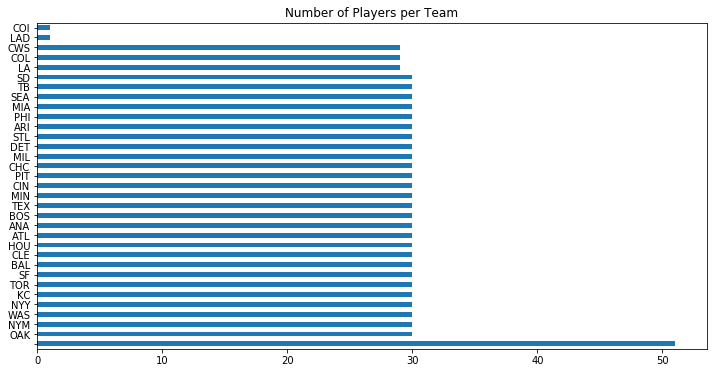

In [304]:
# plot the number of players per team
df['team_file_code'].value_counts().plot('barh', title='Number of Players per Team')

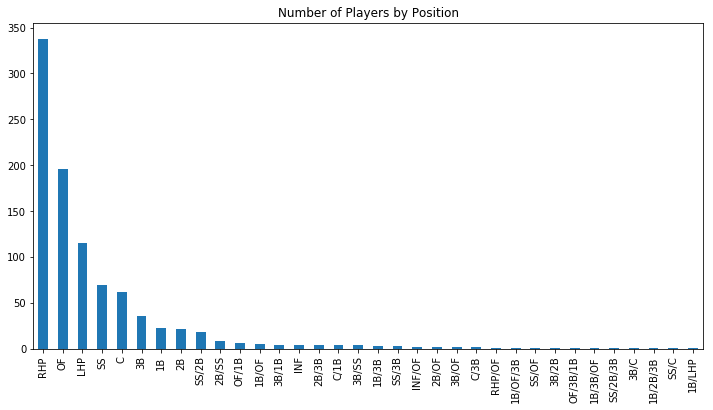

In [302]:
# count the number players by positions
df['positions'].value_counts().plot('bar', title='Number of Players by Position')

[]

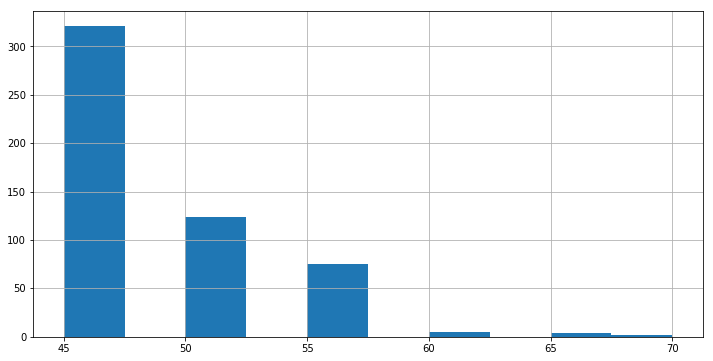

In [299]:
# calculate the average overall score
df['overall'].hist().plot()

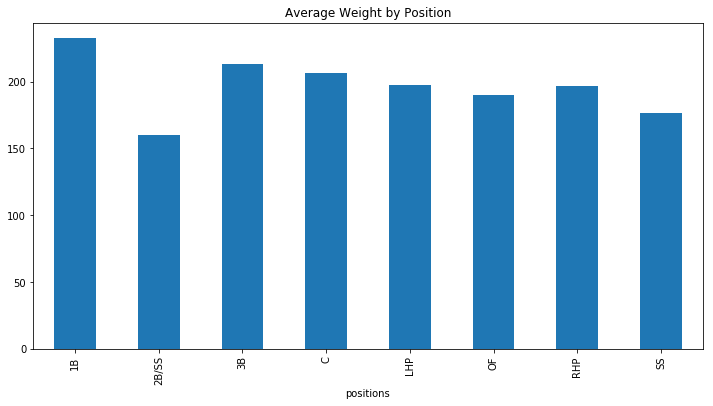

In [297]:
# subset DataFarme to positions and weight
position_weight = df[['positions', 'weight']]

# convert missing to NA
position_weight = position_weight.replace(r'\s+',np.nan,regex=True).replace('',np.nan)

# convert weight to integer
position_weight['weight'] = pd.to_numeric(position_weight['weight'])

# drop records with missing data
position_weight = position_weight.dropna(subset=['positions', 'weight'])

# group by position and calculate the average weight
position_weight.groupby('positions')['weight'].mean().plot('bar', title='Average Weight by Position')

In [240]:
# write the dataframe to CSV
df.to_csv("2018_mlb_prospect_players_info.csv", index=False)